# Regresion Problem

Validation Accuracy: 0.38208185616298074 Mean Loss 0.46976395061220816
Validation Accuracy: 0.4477910479237586 Mean Loss 0.48741193903389324
Validation Accuracy: 0.7089606988821643 Mean Loss 0.13358464367971448
Validation Accuracy: 0.6817102516833394 Mean Loss 0.12898061394091057
Validation Accuracy: 0.6876503756563047 Mean Loss 0.15741070120429543
Validation Accuracy: 0.7635770163068741 Mean Loss 0.0958202258169698
Validation Accuracy: 0.7770046002068323 Mean Loss 0.07520512450590736
Validation Accuracy: 0.7851696861280981 Mean Loss 0.08503979075613656
Validation Accuracy: 0.747916678353014 Mean Loss 0.08147949356137536
Validation Accuracy: 0.7964309452339056 Mean Loss 0.07091911526216192
Validation Accuracy: 0.7699392705268467 Mean Loss 0.07086966726323272
Validation Accuracy: 0.7349399266561211 Mean Loss 0.08946605365089211
Validation Accuracy: 0.8055930276296304 Mean Loss 0.06616476600748464
Validation Accuracy: 0.7289995787290723 Mean Loss 0.1168573263671537
Validation Accuracy: 0

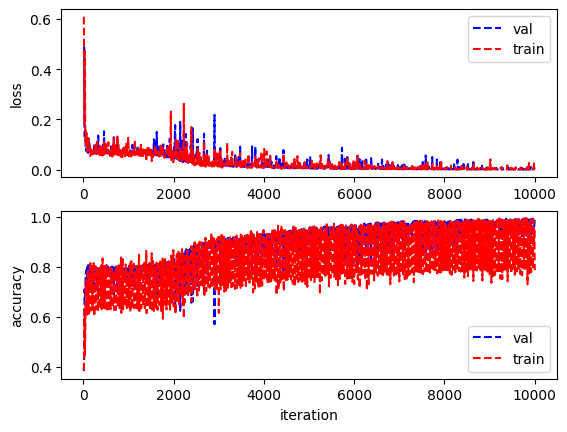

In [16]:
from data.config import *
from data.dataset import *
from report.dumps import *
from nn.model import model
from nn.funcs import *
import numpy as np

def test(ds, verbose=False, phase="Validation", acc_func=batch_hits):
    ds.reset()
    hits = 0
    mean_loss = 0
    while not(ds.iter_done()):
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y, train=False)
        hits += np.sum(acc_func(o, y))
        mean_loss += np.sum(batch_loss)
        #if verbose:
        #    print("Loss: " + str(mean_loss), " Predicted: " + str(o), " Expected: " + str(y))
    accuracy = float(hits) / float(ds.size)
    mean_loss = float(mean_loss) / float(ds.size)
    if verbose:
        print(f"{phase} Accuracy: {str(accuracy)} Mean Loss {str(mean_loss)}")
    return accuracy, mean_loss

def train(nn, hp, val_hist, train_hist, logger, acc_func=batch_hits):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        hits = 0
        cur_trained = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            #print(y)
            o, batch_loss = nn.forward(x, y)
            nn.backward(y,o)
            nn.update(hp.lr)

            hits += np.sum(acc_func(o, y))
            cur_trained += len(x)
            train_loss += np.sum(batch_loss)

            if cur_iter % hp.validate_every_no_of_batches == 0:

                train_accuracy = float(hits) / float(cur_trained)
                train_loss = float(train_loss) / float(cur_trained)
                train_hist.add(cur_iter, train_loss, train_accuracy)
                logger.write( (cur_epoch, "Training", cur_iter, train_accuracy, train_loss) )
                hits = 0
                train_loss = 0

                val_accuracy, val_loss = test(hp.ds_val, True, acc_func=acc_func)
                val_hist.add(cur_iter, val_loss, val_accuracy)
                logger.write( (cur_epoch, "Val", cur_iter, val_accuracy, val_loss) )
            cur_iter+=1
        cur_epoch+=1
        hp.ds_train.reset()
    return val_hist

hp = hyperparams(ConfigEnum.SIN)

nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, sigmoid, sigmoid_grad, has_dropout=hp.has_dropout, dropout_perc=hp.dropout_perc, loss_type="mse")

val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Accuracy", "Loss") )
train(nn, hp, val_hist, train_hist, logger, acc_func=mean_absolute_error)
test(hp.ds_test, verbose=True, phase="Test", acc_func=mean_absolute_error)
nnplotter.view(val_hist, train_hist) #see results on plot
logger.close()